# 3. Encoding
In this stage of the project, we are going to input the encoding to the categorical variables. The ML models only allow us to use numbers, so it is of upmost importance to change these for right numerical variables:
- Using LabelEncoder() from scikit-klearn for binary variables.
- OnehotEncoder() for the multi-categorical variables.

After that, we have to apply log transform to several columns to overcome the strong skewness they have.

Let's import the necessary libraries and the data, free of outliers.

In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


In [158]:
df = pd.read_csv("../data/data_outliers_free.csv")

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94128 entries, 0 to 94127
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   fuel_type                    94128 non-null  object 
 1   mileage_km                   94128 non-null  float64
 2   body_type                    94128 non-null  object 
 3   transmission                 94128 non-null  object 
 4   power_hp                     94128 non-null  float64
 5   warranty_months              87647 non-null  float64
 6   emissions_label              87631 non-null  object 
 7   price                        94128 non-null  float64
 8   length_mm                    70369 non-null  float64
 9   width_mm                     70522 non-null  float64
 10  height_mm                    70358 non-null  float64
 11  wheelbase_mm                 70552 non-null  float64
 12  weight_kg                    70552 non-null  float64
 13  doors           

In [160]:
df.isna().sum()

fuel_type                          0
mileage_km                         0
body_type                          0
transmission                       0
power_hp                           0
warranty_months                 6481
emissions_label                 6497
price                              0
length_mm                      23759
width_mm                       23606
height_mm                      23770
wheelbase_mm                   23576
weight_kg                      23576
doors                          23577
seats                          23576
engine_displacement_cm3        23576
cylinders                      25591
turbo                          23576
consumption_city_l_100km       23576
consumption_highway_l_100km    23576
consumption_mixed_l_100km      23576
co2_g_km                       40422
tank_capacity_l                23576
registration_month                 0
registration_year                  0
trunk_dim_1                    23576
trunk_dim_2                    23576
d

_________________________

## Encode categorical variables
Categorical variables are those with a data type 'object' plus registration_year, registration_month, cylinders, seats and doors. The last ones have already a numeric data type, but since they're actually categories, we're going to have to encode them.

In [161]:
df_encoding = pd.concat([df.select_dtypes(exclude='number'), df[['registration_year', 'registration_month', 'cylinders', 'seats', 'doors']]], axis=1)
df_encoding.head()

,fuel_type,body_type,transmission,emissions_label,turbo,registration_year,registration_month,cylinders,seats,doors
0,Petrol,Sedan,Manual,C,NaN,2023,2,NaN,NaN,NaN
1,Petrol,Sedan,Manual,C,NaN,2023,6,NaN,NaN,NaN
2,Electric,Sedan,Automatic,0 EMISSIONS,Turbo,2023,9,NaN,4.0,3.0
3,Electric,Sedan,Automatic,0 EMISSIONS,Turbo,2023,10,NaN,4.0,3.0
4,Electric,Sedan,Automatic,0 EMISSIONS,Turbo,2023,8,NaN,4.0,3.0


__________________________
### Encoding binary variables - LabelEncoder
We have 2 binary variables here:
- transmission
- turbo

We can use the LabelEncoder directly with transmission, however, we need to apply some transformations in the turbo column, sice the turbo type is specified. We only going to keep if the car has turbo or not.

#### transmission
Instead of using the LabelEncoder, we're going to map the entire column. There are no NaN's already, so we apply 1 for automatic cars and rename the column to indicate weather a car is automatic or not, to match the criterion.

In [162]:
df_encoding['transmission_auto'] = df_encoding['transmission'].map({'Automatic': 1, 'Manual': 0})
df_encoding.drop(columns=['transmission'], inplace=True)

In [163]:
df_encoding['transmission_auto'].unique()

array([0, 1])

#### turbo
We only keep if the car has turbo or not. We keep the NaN's.

In [164]:
df_encoding['turbo'].unique()

array([nan, 'Turbo', 'Not specified', 'Variable geometry turbo',
       'Twin-turbo', 'Type of forced induction', 'Lysholm supercharger',
       'Roots supercharger', 'Supercharger and turbo'], dtype=object)

In [165]:
turbo_values = [
 'Turbo',
 'Variable geometry turbo',
 'Twin-turbo',
 'Type of forced induction',
 'Lysholm supercharger',
 'Roots supercharger',
 'Supercharger and turbo'
 ]

df_encoding['turbo'] = df_encoding['turbo'].apply(
    lambda x: 1 if x in turbo_values else (0 if x == 'Not specified' else np.nan)
)

In [166]:
df_encoding['turbo'].unique()

array([nan,  1.,  0.])

_______________________________
### Encoding multi-categorical variables - OneHot Encoding
This technique creates a column for each different value of each category, so they will contain only zeros and ones. Theproblem with this technique is that it significantly increases the number of columns, therefore the dataframe size, leading to slower performance. We can use some tricks with some of the columns to avoid that. Others, will have to be increased anyways.

#### OneHot Encoding
For most of the columns, we can use a regular One Hot encoding, as shown below:

In [167]:
df_encoding.columns

Index(['fuel_type', 'body_type', 'emissions_label', 'turbo',
       'registration_year', 'registration_month', 'cylinders', 'seats',
       'doors', 'transmission_auto'],
      dtype='object')

In [168]:
onehot_list = ['fuel_type', 'body_type', 'emissions_label', 'cylinders', 'seats', 'doors']


Bear in mind that we still keep the NaN's.

In [169]:
# create the encoding object; sparse_output=False returns ndarray (easy handling), handle_unknowk='ignore' when NaNs or unexpected values can be present avoids crashing
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# get a copy of the dataframe only with the columns we're encoding here
df_cat = df_encoding[onehot_list]

# fit-transform
oh_array = onehot_encoder.fit_transform(df_cat)

# create the independent df with the encoded columns; it has to keep the indexing to match the df_encoding
df_oh = pd.DataFrame(oh_array, columns=onehot_encoder.get_feature_names_out(onehot_list), index=df_encoding.index)

#concatenate the original df with the encoded one, droping the original columns
df_encoding = pd.concat([df_encoding.drop(columns=onehot_list), df_oh], axis=1)

In [170]:
df_encoding.head()

,turbo,registration_year,registration_month,transmission_auto,fuel_type_Diesel,fuel_type_Electric,fuel_type_Gas,fuel_type_Hybrid,fuel_type_Petrol,fuel_type_Petrol/Ethanol,...,seats_6.0,seats_7.0,seats_8.0,seats_9.0,seats_nan,doors_2.0,doors_3.0,doors_4.0,doors_5.0,doors_nan
0,NaN,2023,2,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,NaN,2023,6,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1.0,2023,9,1,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,2023,10,1,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,2023,8,1,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


__________________________
### Out-of-the-box encodings
Only 2 variables left: 
- registration_year
- registration_month

We're going to transform these variables into a more convenient format. If we use the OneHot encoder, the result is a column for every single year and every month we have in the dataframe, impacting the algorithm performance. Furthermore, if there are some kind of seasonal pattern, the algorithm won't be able to catch it. For example: the months January and December are one after another, close in time. This can be an important information that we should not ignore. Let's see now how to move on.

_______________________
#### registration_year
We have different registration years, each of them is categorical. We can turn that variable into a continuous one by gettin the "car age" instead of the year itself. This way, we will only have 1 column, not even an extra one, since we can drop the original.

In [171]:
df_encoding['car_age'] = df_encoding['registration_year'].apply(lambda x: 2025-x)

In [172]:
df_encoding.drop(columns='registration_year', inplace=True)

#### registration_month
Here, we can apply a sinusoidal or cyclical encoding. We're going to encode the month as sinusoidal coordinates, so the algorithm can catch much better the proximity between months wich are closer between them. We also avoid getting 12 extra columns.

In [173]:
df['reg_month_sin'] = np.sin(2 * np.pi * df['registration_month'] / 12)
df['reg_month_cos'] = np.cos(2 * np.pi * df['registration_month'] / 12)

In [174]:
df_encoding.drop(columns='registration_month', inplace=True)

In [175]:
df_encoding.head()

,turbo,transmission_auto,fuel_type_Diesel,fuel_type_Electric,fuel_type_Gas,fuel_type_Hybrid,fuel_type_Petrol,fuel_type_Petrol/Ethanol,fuel_type_Petrol/Gas,fuel_type_Plug-in Hybrid,...,seats_7.0,seats_8.0,seats_9.0,seats_nan,doors_2.0,doors_3.0,doors_4.0,doors_5.0,doors_nan,car_age
0,NaN,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2
1,NaN,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2
2,1.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2
3,1.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2
4,1.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2


### Put everything together
Let's now concatenate the copy of the original df with the encodings:

In [176]:
onehot_list + ['turbo', 'transmission']

['fuel_type',
 'body_type',
 'emissions_label',
 'cylinders',
 'seats',
 'doors',
 'turbo',
 'transmission']

In [177]:
df_model = pd.concat([df.drop(columns=onehot_list + ['turbo', 'transmission', 'registration_year', 'registration_month']), df_encoding], axis=1)

Check the data types to ensure all of them are numeric.

In [178]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94128 entries, 0 to 94127
Data columns (total 71 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   mileage_km                                94128 non-null  float64
 1   power_hp                                  94128 non-null  float64
 2   warranty_months                           87647 non-null  float64
 3   price                                     94128 non-null  float64
 4   length_mm                                 70369 non-null  float64
 5   width_mm                                  70522 non-null  float64
 6   height_mm                                 70358 non-null  float64
 7   wheelbase_mm                              70552 non-null  float64
 8   weight_kg                                 70552 non-null  float64
 9   engine_displacement_cm3                   70552 non-null  float64
 10  consumption_city_l_100km          

## Correlations
Before saving the data for the next step. we can make  small analysis to check if there are highly correlated variables. When 2 variables are highly correlated, they're not really giving us extra information, so we can keep only one of them. Actually, there are some candidates for that. Those related to the cars consumption are very likely saying the same.

In [179]:
df_model.columns

Index(['mileage_km', 'power_hp', 'warranty_months', 'price', 'length_mm',
       'width_mm', 'height_mm', 'wheelbase_mm', 'weight_kg',
       'engine_displacement_cm3', 'consumption_city_l_100km',
       'consumption_highway_l_100km', 'consumption_mixed_l_100km', 'co2_g_km',
       'tank_capacity_l', 'trunk_dim_1', 'trunk_dim_2', 'reg_month_sin',
       'reg_month_cos', 'turbo', 'transmission_auto', 'fuel_type_Diesel',
       'fuel_type_Electric', 'fuel_type_Gas', 'fuel_type_Hybrid',
       'fuel_type_Petrol', 'fuel_type_Petrol/Ethanol', 'fuel_type_Petrol/Gas',
       'fuel_type_Plug-in Hybrid', 'fuel_type_Plug-in Hybrid Diesel/Electric',
       'fuel_type_Plug-in Hybrid Petrol/Electric', 'body_type_Commercial',
       'body_type_Convertible', 'body_type_Coupe', 'body_type_Coupe/Sports',
       'body_type_Estate', 'body_type_MPV', 'body_type_Pickup',
       'body_type_Roadster', 'body_type_SUV', 'body_type_SUV/Pickup',
       'body_type_Sedan', 'body_type_Small', 'body_type_Targa',
   

In [180]:
high_corr = []
for col in df_model.columns:
    if -0.3 < df_model[[col, 'price']].corr().iloc[0,1] < 0.3:
        pass
    else: 
        high_corr.append(col)

len(high_corr)

9

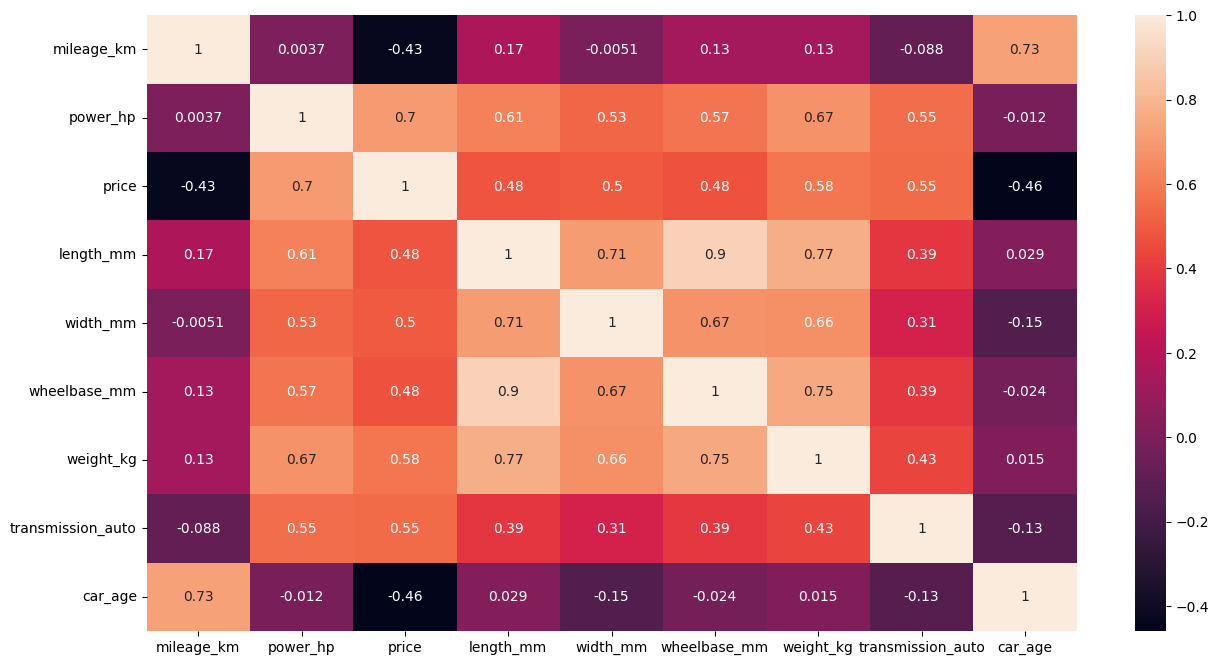

In [181]:
plt.figure(figsize = (15, 8))

sns.heatmap(df_model[high_corr].corr(), annot = True)
plt.show()

We can see that the price has the highest correlation with power. It's a positive correlation that makes sense (more power, more expensive car). The same happens with dimensional varibles and transmission. Bigger cars are usually more expensive,as well as the automatic ones.

The car age and the mileage are negative correlations that also make sense. The older the car is and the more distance the car has made, the cheaper it gets.

### Fuel consumption
We're going to drop city and highway consumption, since they're all highly correlated. They're not giving us new information and mixed is a good overall aproximation. We might keep the emmissions, just in case we prefer to emphathize this approach with the ML algorithms, although keeping the mixed consumption could be more interpretable. In any case, we will decide it after applying Feature importances. Here, we can observe the high correlation:

In [182]:
high_corr = []
for col in ['co2_g_km', 'consumption_city_l_100km', 'consumption_highway_l_100km', 'consumption_mixed_l_100km']:
    if -0.8 < df_model[[col, 'co2_g_km']].corr().iloc[0,1] < 0.8:
        pass
    else: 
        high_corr.append(col)

len(high_corr)

4

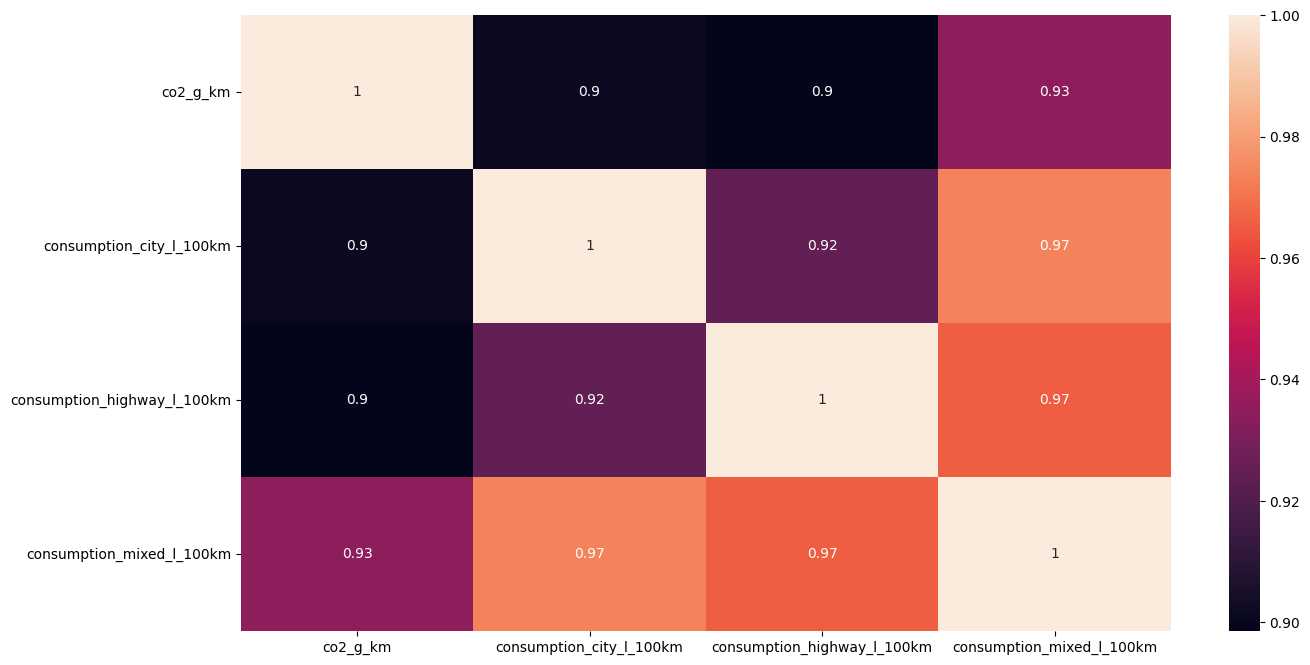

In [183]:
plt.figure(figsize = (15, 8))

sns.heatmap(df_model[high_corr].corr(), annot = True)
plt.show()

In [184]:
df_model.drop(columns=['consumption_city_l_100km', 'consumption_highway_l_100km'], inplace=True)

Let's save this df so we can use it in the final stage before modelling.

In [185]:
df_model.to_csv('../data/data_encoded.csv', index=False)